# Comparison between local analysis and global analysis

In [32]:
import toml
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from itertools import combinations_with_replacement

from app.task import load_data, generate_gwas_dataset, compute_allele_frequencies_np, count_alleles, compute_maf  

# Loading parameters from TOML file
toml_file = "pyproject.toml"
config = toml.load(toml_file)
params = config["tool"]["flwr"]["app"]["config"]

num_partitions = 5

# MAybe we could force a allele frequency to be < 0.05 so that it would be excluded in a clinet while in the global analysis it wouldnt 

## Federated analysis

Here we read the results of the FL process and show the results.

In [33]:
federated_maf = pd.read_csv('./maf_out.csv',index_col=0)
federated_maf

,MAF
SNP_1,0.119996
SNP_2,0.054998
SNP_3,0.069990
SNP_4,0.064988
SNP_5,0.110002


## Centralized analysis

Here, we aggregate the datasets from the different clients participating in the FL process and perform the analysis in a centralized manner. Note that the results are <b>identical</b> to those obtained through FL. However, it's important to note that this approach would not be feasible in a real-world scenario where only FL is authorized.

In [34]:
# Concatenate all partitions into a single dataset
all_partitions = []
for i in range(num_partitions):  
    data = load_data(i, num_partitions, params["num_individuals"], 
                     num_snps = params["num_snps"], seed_value =
                     params["seed_value"]
                    )

    if i==0 :
        print("Example of local dataset:")
        display(data)
    all_partitions.append(data)
centralized_df = pd.concat(all_partitions)


Example of local dataset:


,SNP_1,SNP_2,SNP_3,SNP_4,SNP_5
0,GG,AC,CC,GG,GT
1,GT,GG,GT,CG,TT
2,AA,CC,GG,AA,CT
3,AG,AC,GT,CG,AG
4,AG,AT,GT,AC,AG
...,...,...,...,...,...
195,AT,CC,GT,AC,GG
196,AA,AG,AA,CC,CG
197,AC,AC,TT,TT,AG
198,AC,AT,GT,GT,CG


In [35]:
centralized_counts = count_alleles(centralized_df)
centralized_counts

,A_count,C_count,G_count,T_count,Total_Alleles
SNP_1,569,505,422,504,2000
SNP_2,982,342,380,296,2000
SNP_3,289,233,774,704,2000
SNP_4,456,591,471,482,2000
SNP_5,295,392,984,329,2000


In [36]:
allele_frequencies_np = compute_allele_frequencies_np(centralized_counts)
allele_frequencies_np

array([[0.2845, 0.2525, 0.211 , 0.252 ],
       [0.491 , 0.171 , 0.19  , 0.148 ],
       [0.1445, 0.1165, 0.387 , 0.352 ],
       [0.228 , 0.2955, 0.2355, 0.241 ],
       [0.1475, 0.196 , 0.492 , 0.1645]])

In [37]:
centralized_maf = compute_maf(allele_frequencies_np)
centralized_maf

array([0.211 , 0.148 , 0.1165, 0.228 , 0.1475])

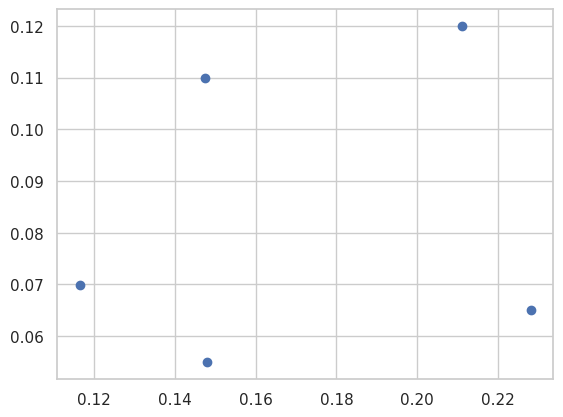

In [38]:
plt.scatter(centralized_maf,federated_maf.MAF.values)
plt.show()

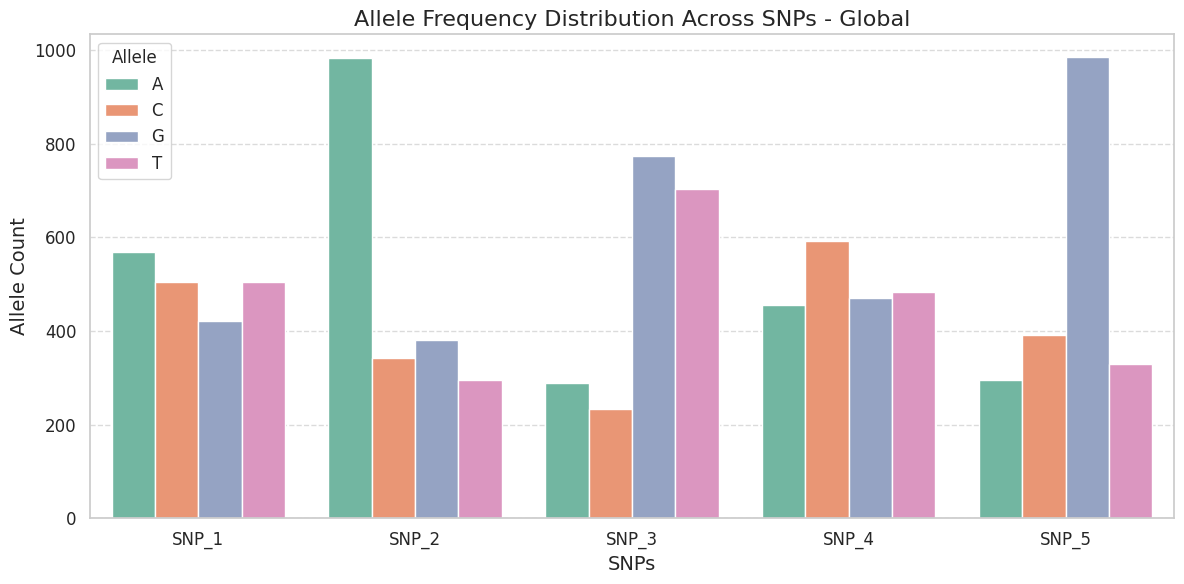

In [25]:
# Convert to long format for Seaborn
#df = pd.DataFrame(allele_counts_df)
df= centralized_counts
df['SNP'] = df.index
allele_data = df.melt(id_vars=["SNP"], value_vars=["A_count", "C_count", "G_count", "T_count"],
                      var_name="Allele", value_name="Count")

# Clean up allele names (remove "_count" from column names)
allele_data["Allele"] = allele_data["Allele"].str.replace("_count", "")

# Set Seaborn style
sns.set(style="whitegrid")

# Create the bar plot
plt.figure(figsize=(12, 6))  # Set figure size
ax = sns.barplot(x="SNP", y="Count", hue="Allele", data=allele_data, palette="Set2")

# Customize plot
plt.xlabel("SNPs", fontsize=14)
plt.ylabel("Allele Count", fontsize=14)
plt.title("Allele Frequency Distribution Across SNPs - Global", fontsize=16)
plt.xticks(rotation=0, fontsize=12)  # Keep SNP labels readable
plt.yticks(fontsize=12)
plt.legend(title="Allele", fontsize=12)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()

## Local analysis

Here, we present the results each client would obtain by analyzing their dataset independently. Notably, using the default seed value from the configuration file

In [26]:
# Concatenate all partitions into a single dataset
partitions = []
for i in range(num_partitions):  
    data = load_data(i, num_partitions, params["num_individuals"], 
                     num_snps = params["num_snps"], seed_value =
                     params["seed_value"]
                    )
    partitions.append((i,data))


In [30]:
values= np.stack([compute_maf(compute_allele_frequencies_np(count_alleles(t[1]))) for t in partitions ])
cases = ['Partition 1', 'Partition 2', 'Partition 3', 'Partition 4', 'Partition 5']
categories = ['SNP_1', 'SNP_2', 'SNP_3', 'SNP_4','SNP_5']


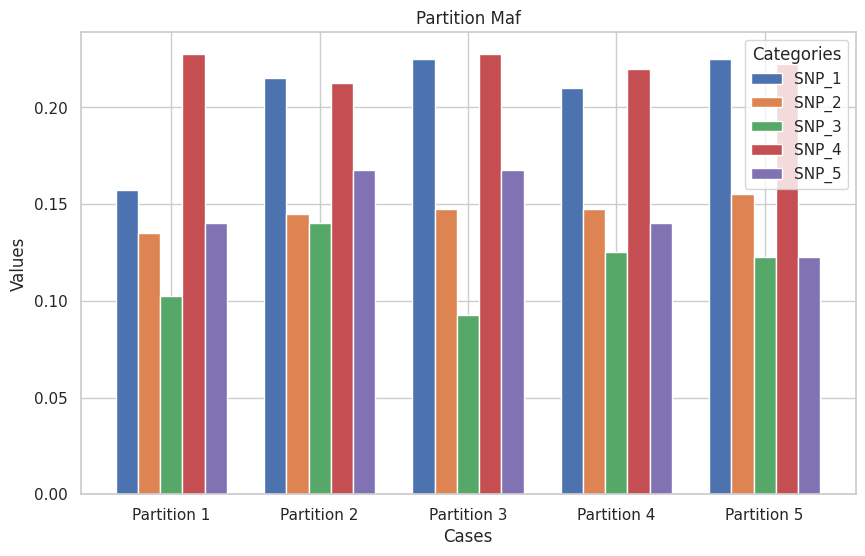

In [31]:
# Bar width and x positions
x = np.arange(len(cases))  # Positions for each case
bar_width = 0.15  # Width of each bar

# Plot
plt.figure(figsize=(10, 6))

for i in range(len(categories)):
    plt.bar(x + i * bar_width, values[:, i], width=bar_width, label=categories[i])

# Formatting
plt.xticks(x + bar_width * (len(categories) / 2 - 0.5), cases)  # Center x labels
plt.xlabel('Cases')
plt.ylabel('Values')
plt.title('Partition Maf')
plt.legend(title='Categories')

# Show plot
plt.show()

# Find the interesting case

In [ ]:
for s in range(1,1000):
    d = generate_gwas_dataset(100, 5, s, 0.05)
    c = count_alleles(d)
    f = compute_allele_frequencies_np(c)
    m = compute_maf(f)
    if np.all(m != 0):
        print("All elements are different from 0")
        print(s,m)
            

In [17]:
for s in range(1,1000):
    d = generate_gwas_dataset(100, 5, s, 0.05)
    c = count_alleles(d)
    f = compute_allele_frequencies_np(c)
    m = compute_maf(f)
    if np.all(m != 0):
        print("All elements are different from 0")
        print(s,m)    
    

All elements are different from 0
16 [0.12  0.055 0.07  0.065 0.11 ]
All elements are different from 0
20 [0.11  0.095 0.13  0.175 0.075]
All elements are different from 0
57 [0.17  0.065 0.165 0.08  0.2  ]
All elements are different from 0
93 [0.085 0.085 0.055 0.02  0.105]
All elements are different from 0
113 [0.135 0.11  0.1   0.095 0.14 ]
All elements are different from 0
131 [0.065 0.06  0.085 0.1   0.105]
All elements are different from 0
163 [0.095 0.075 0.055 0.055 0.17 ]
All elements are different from 0
173 [0.105 0.12  0.075 0.105 0.155]
All elements are different from 0
214 [0.09  0.11  0.12  0.135 0.09 ]
All elements are different from 0
255 [0.205 0.155 0.15  0.07  0.04 ]
All elements are different from 0
263 [0.155 0.125 0.07  0.075 0.11 ]
All elements are different from 0
279 [0.03  0.125 0.105 0.18  0.215]
All elements are different from 0
287 [0.115 0.12  0.125 0.13  0.15 ]
All elements are different from 0
307 [0.095 0.15  0.095 0.05  0.05 ]
All elements are differe